## 04. PyTorch Custom Datasets

https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

![Alt text](image-1.png)

### 1. Get data

여기서는 food101 dataset을 사용한다.  
- https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

본 교재에서는 아래 코드로 데이터셋을 정리한 것이다.  
- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

여기서는 이 데이터셋을 사용한다.  
- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


### 2. 데이터 준비

os.walk() 함수를 사용하면 디렉토리 내부 정보를 확인할 수 있다.

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


즉 디렉토리 구조가 다음과 같아야 함

![Alt text](image-2.png)

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

이미지 시각화

- 경로 아래에 이미지 파일을 리스트업 : using pathlib.Path.glob() to find all of the files ending in .jpg.
- Pick a random image path using Python's random.choice().
- Get the image class name using pathlib.Path.parent.stem.
- And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
- We'll then show the image and print some metadata.

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
#img

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### 3. Transforming data

- 이미지 데이터를 텐서로 변환  
- 이 텐서 데이터를 torch.utils.data.Dataset으로 변환하고, torch.utils.data.DataLoader에 탑재

파이토치에는 pre-built 데이터셋이 제공된다.

여기서는 비전 문제를 다루기 때문에 데이터 로딩을 위해 torchvision.datasets, transforms를 사용한다.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with torchvision.transforms

먼저 이미지 데이터를 텐서로 변환한다.  
변환하는 방법은 torchvision.transform 모듈을 사용하는 것이다.  
이 모듈에는 이미지를 포매팅하고, 이를 텐서로 변환하고, 증강하는 메서드를 제공한다.  
여러가지 변환, 증강은 torchvision.transforms.Compose()로 컴파일할 수 있다.

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

In [12]:

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

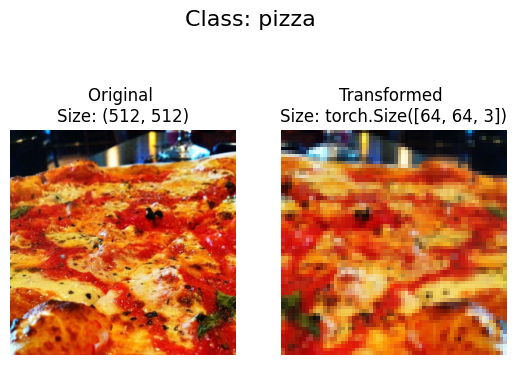

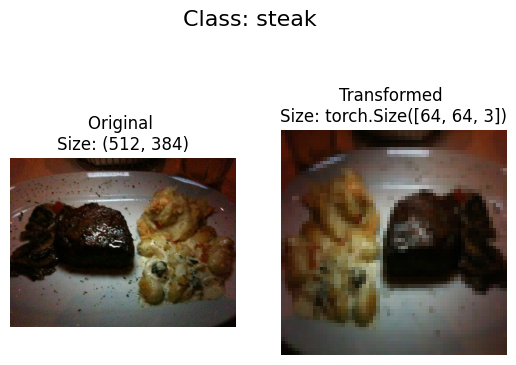

In [13]:
plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### 4. Option 1: Loading Image Data Using ImageFolder

이제 이미지 데이터를 Dataset으로 바꿀차례다.   
표준 이미지 분류 포맷에서는 torchvision.datasets.ImageFolder를 사용할 수 있다.  

이 경우에는  데이터의 경로를 지정하면 된다.

In [14]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [15]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [16]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [17]:
print(train_data.classes)
print(train_data.class_to_idx)
class_names = train_data.classes
class_dict = train_data.class_to_idx

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
print(train_data[0][0].shape)
print(train_data[0][1])

torch.Size([3, 64, 64])
0


In [20]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

- 이미지가 [3, 64, 64] 형태로, 그리고 레이블과 함께 저장되었다.   
- matplotlib으로 플로팅 하려면 데이터 shape를 변환해야한다. CHW -> HWC

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


#### 4.1 Turn loaded images into DataLoader's

In [22]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x13b09ae20>,
 <torch.utils.data.dataloader.DataLoader at 0x13b09a550>)

In [23]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### 5. Option 2: Loading Image Data with a Custom Dataset

ImageFolder를 사용할 수 있는 경로가 없을 때는 어떻게 해야할까?   
커스텀으로 만들면 된다.   
커스텀 데이터셋을 만드는 것의 장단점은 다음과 같다.

동작원리를 확인하기 위해 torch.utils.data.Dataset를 서브클래싱해서 torchvision.datasets.ImageFolder()를 만들어보자.   
이를 위해 필요한 라이브러리는 다음과 같다.

- os : 디렉토리 다루기
- pathlib : 파일 경로 다루기(각 이미지는 고유의 파일경로를 가짐  
- torch  
- PIL.Image : 이미지 로딩
- torch.utils.data.Dataset : 서브클래싱하여 커스템 데이터셋을 생성하기 위함  
- torchvision.transforms : 이미지를 텐서로 만들기  
- typing : 타입 힌트

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating a helper function to get class names

클래스명과 클래스 딕셔너리를 생성하는 함수를 만들자.

- Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
- Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
- Turn the class names into a dictionary of numerical labels, one for each class.

이 중에서 첫번째만 시도해보자.

In [26]:
image_path

PosixPath('data/pizza_steak_sushi')

In [27]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [28]:
list(os.scandir(image_path / "train"))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [29]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [30]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [31]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

ImageFolder 기능을 하는 custom Dataset 만들기

- 1. torch.utils.data.Dataset을 서브클래싱한다.  
- 2. 서브클래스를 targ_dir, transform 파라미터로 초기화 한다.  
- 3. 몇가지 속성을 생성한다. : paths, transform, classes, class_to_idx  
- 4. PIL or torchvision.io를 파일로부터 이미지를 읽어서 리턴하는 함수를 만든다.  
- 5. 샘플의 수를 린턴하는 `__len__` 메서드를 오버라이트 한다.(선택)
- 6. 데이터의 단일 샘플을 리턴하는 `__getitem__`를 오버라이트 한다.(필수)

In [32]:
from torch.utils.data import Dataset

In [33]:
class ImageFolderCustom(Dataset):
    
    def __init__(self, targ_dir: str, transform = None) -> None:
        
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        
        self.transform = transform
        
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

data_loader.py 파일로 분리해두면 유용하다.

In [34]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([ # 증강을 하지 않음에 유의하자.
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [35]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x13b0cf0a0>,
 <__main__.ImageFolderCustom at 0x13b0cfa60>)

In [36]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [40]:
print(len(train_data_custom) == len(train_data))

print(len(test_data_custom) == len(test_data))

True
True


In [41]:
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


Create a function to display random images

Dataset 안의 이미지를 시각화하기 위한 함수를 만들자.    
- 1. Dataset과 부가적인 파라미터(클래스, 이미지 수, 랜덤 시드) 등을 취한다.  
- 2. 인덱스를 랜덤으로 얻는다. random.sample 사용  
- 3. 차트를 그린다. 루프를 돌려서  
- 4. 이때 이미지 shape를 HWC로 설정한다.

In [42]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


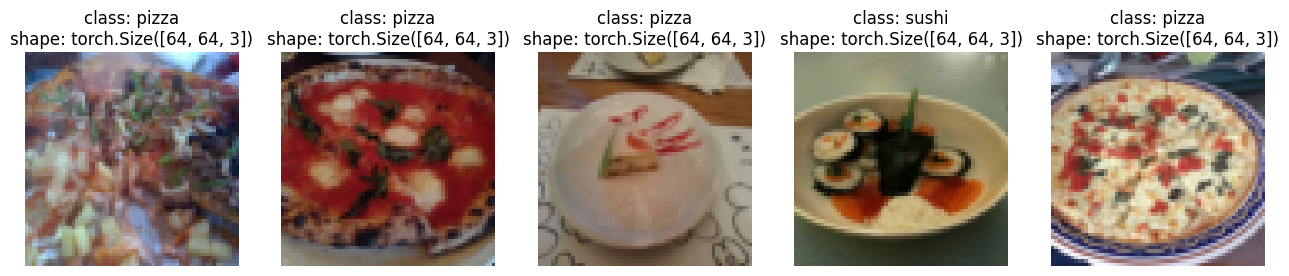

In [43]:
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


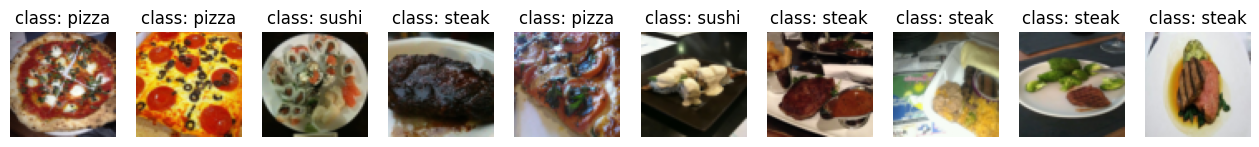

In [44]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

Turn custom loaded images into DataLoader's

In [45]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x13b0e3f70>,
 <torch.utils.data.dataloader.DataLoader at 0x13b1237f0>)

In [46]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### 6. Other forms of transforms (data augmentation)

transforms.RandAugment(), transforms.TrivialAugmentWide() 가 일반적으로 hand-picked transforms보다 성능이 좋다.

The PyTorch team even used TrivialAugment it to train their latest state-of-the-art vision models.

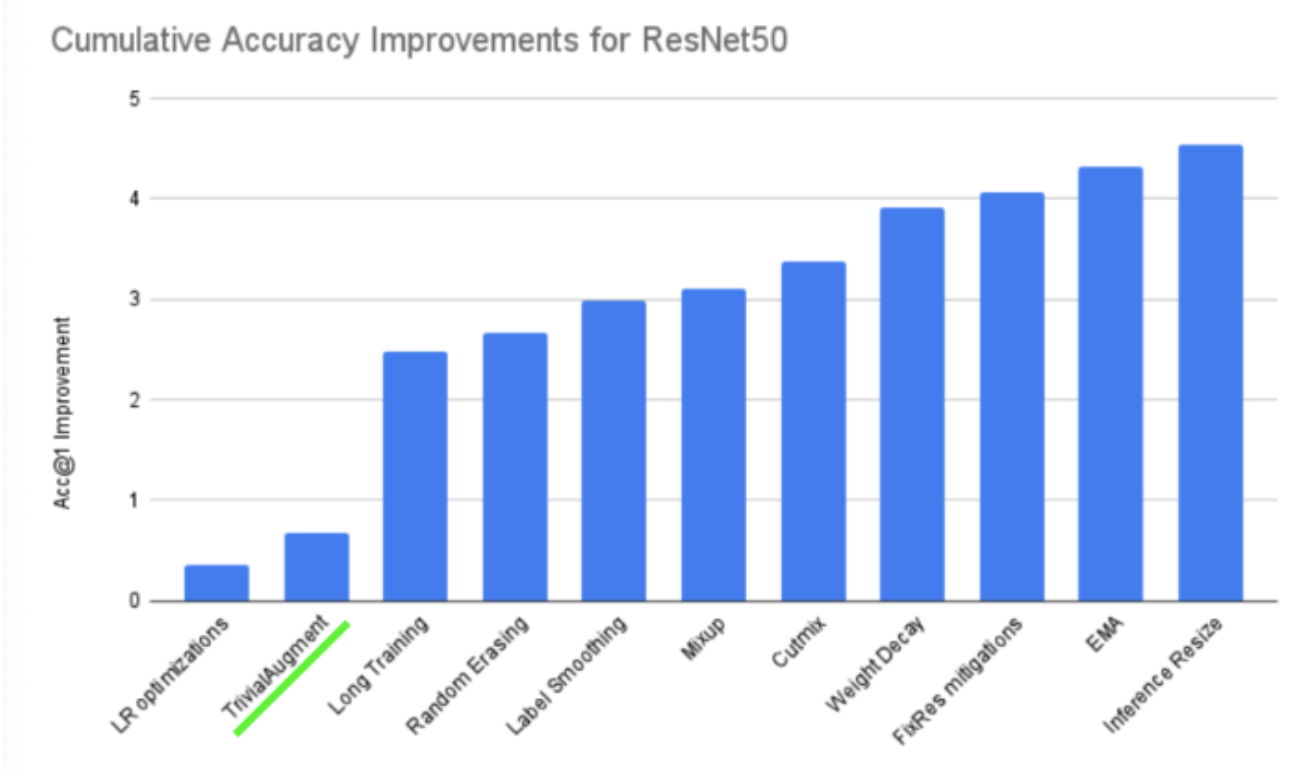

TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.

transforms.TrivialAugmentWide()에서 주목해야 할 주요 파라미터는 num_magnitude_bins=31입니다.

이 값은 특정 트랜스폼을 적용하기 위해 강도 값을 선택할 범위의 범위를 정의하며, 0은 범위가 없고 31은 최대 범위(가장 높은 강도가 적용될 확률이 가장 높음)입니다.

In [47]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [48]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi

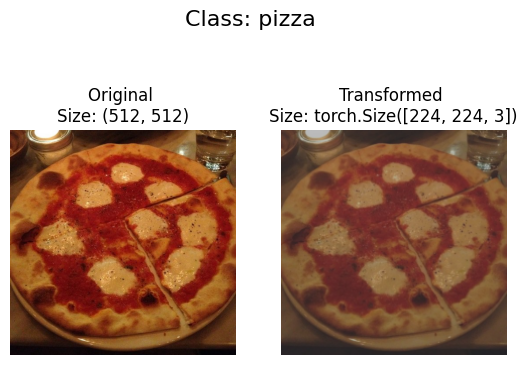

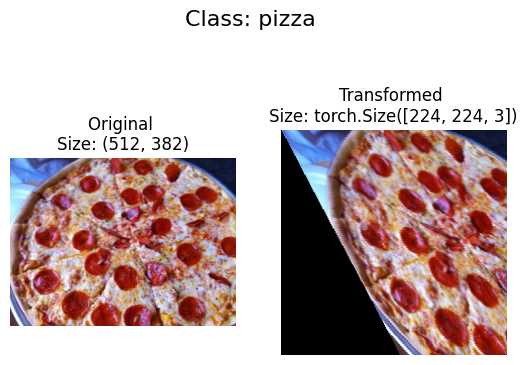

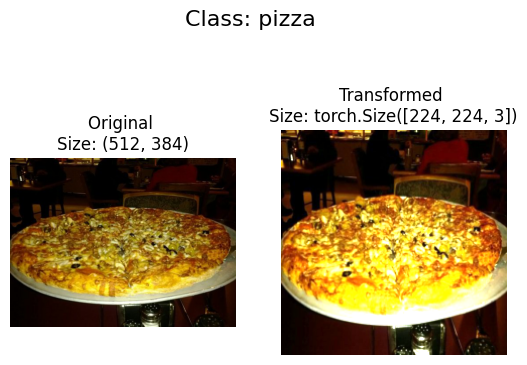

In [49]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

### 7. Model 0: TinyVGG without data augmentation

In [51]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

- 토치비전의 datasets.ImageFolder로 데이터셋 구축  
- DataLoader 구축

In [52]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

Creating DataLoader's with batch size 32 and 10 workers.


In [53]:
train_dataloader_simple = DataLoader(train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

Create TinyVGG model class

- https://poloclub.github.io/cnn-explainer/

여기서는 컬러이미지라서 in_channels = 3 임에 유의하자.

In [54]:
class TinyVGG(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                     out_features=output_shape),
        )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        
        return x

In [55]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # 채널
               hidden_units=10,
               output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

참고: GPU에서 딥 러닝 모델 계산 속도를 높이는 방법 중 하나는 연산자 융합을 활용하는 것입니다.

**즉, 위 모델의 forward() 메서드에서는 레이어 블록을 호출하고 매번 x를 재할당하는 대신 각 블록을 연속적으로 호출합니다(예는 위 모델의 forward() 메서드 마지막 줄 참조).

이렇게 하면 x를 재할당하는 데 소요되는 시간(메모리 사용량)을 절약하고 x에 대한 연산에만 집중할 수 있습니다.**

머신 러닝 모델 속도를 높이는 방법에 대한 자세한 내용은 Horace He의 '첫 번째 원칙에서 딥 러닝을 빠르게 만들기'를 참조하세요.   
- https://horace.io/brrr_intro.html

Try a forward pass on a single image (to test the model)

단일 이미지로 테스트를 진행해보자.

- 데이터로더에서 이미지와 레이블이 포함된 한개 배치 추출
- 배치 안에서 한개 이미지를 추출하고 unsqueeze()하여 배치 사이즈를 1개로 설정
- Perform inference on a single image (making sure to send the image to the target device).
- Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax()  

In [67]:
img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim = 0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0352]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [68]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

Use torchinfo to get an idea of the shapes going through our model

In [70]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

Create train & test loop functions

- train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
- test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
- train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [71]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer
              ):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [72]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Creating a train() function to combine train_step() and test_step()

- Take in a model, a DataLoader for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
- Create an empty results dictionary for train_loss, train_acc, test_loss and test_acc values (we can fill this up as training goes on).
- Loop through the training and test step functions for a number of epochs.
- Print out what's happening at the end of each epoch.
- Update the empty results dictionary with the updated metrics each epoch.
- Return the filled

- tqdm.auto는 자동으로 어떤 프로그래스바가 적절한지 선택해준다. (주피터, 파이썬 스크립트)

In [73]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
         epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

Train and Evaluate Model 0

- torch.nn.CrossEntropyLoss() 
- torch.optim.Adam() 
- learning rate of 1e-3 respecitvely.

In [74]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 

In [75]:
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1697 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1386 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.2930 | test_loss: 1.1430 | test_acc: 0.1979
Total training time: 297.110 seconds


- 모델 성능이 낮은 것 같다.

Plot the loss curves of Model 0

In [76]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [77]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


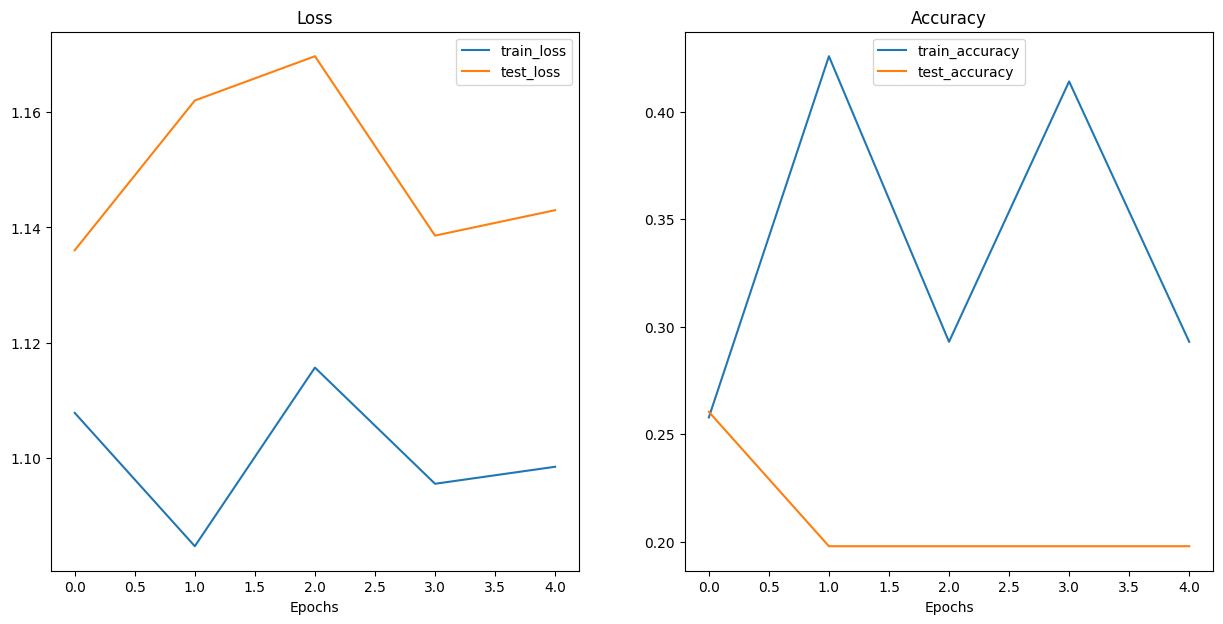

In [78]:
plot_loss_curves(model_0_results)

### 8. What should an ideal loss curve look like?

How to deal with overfitting
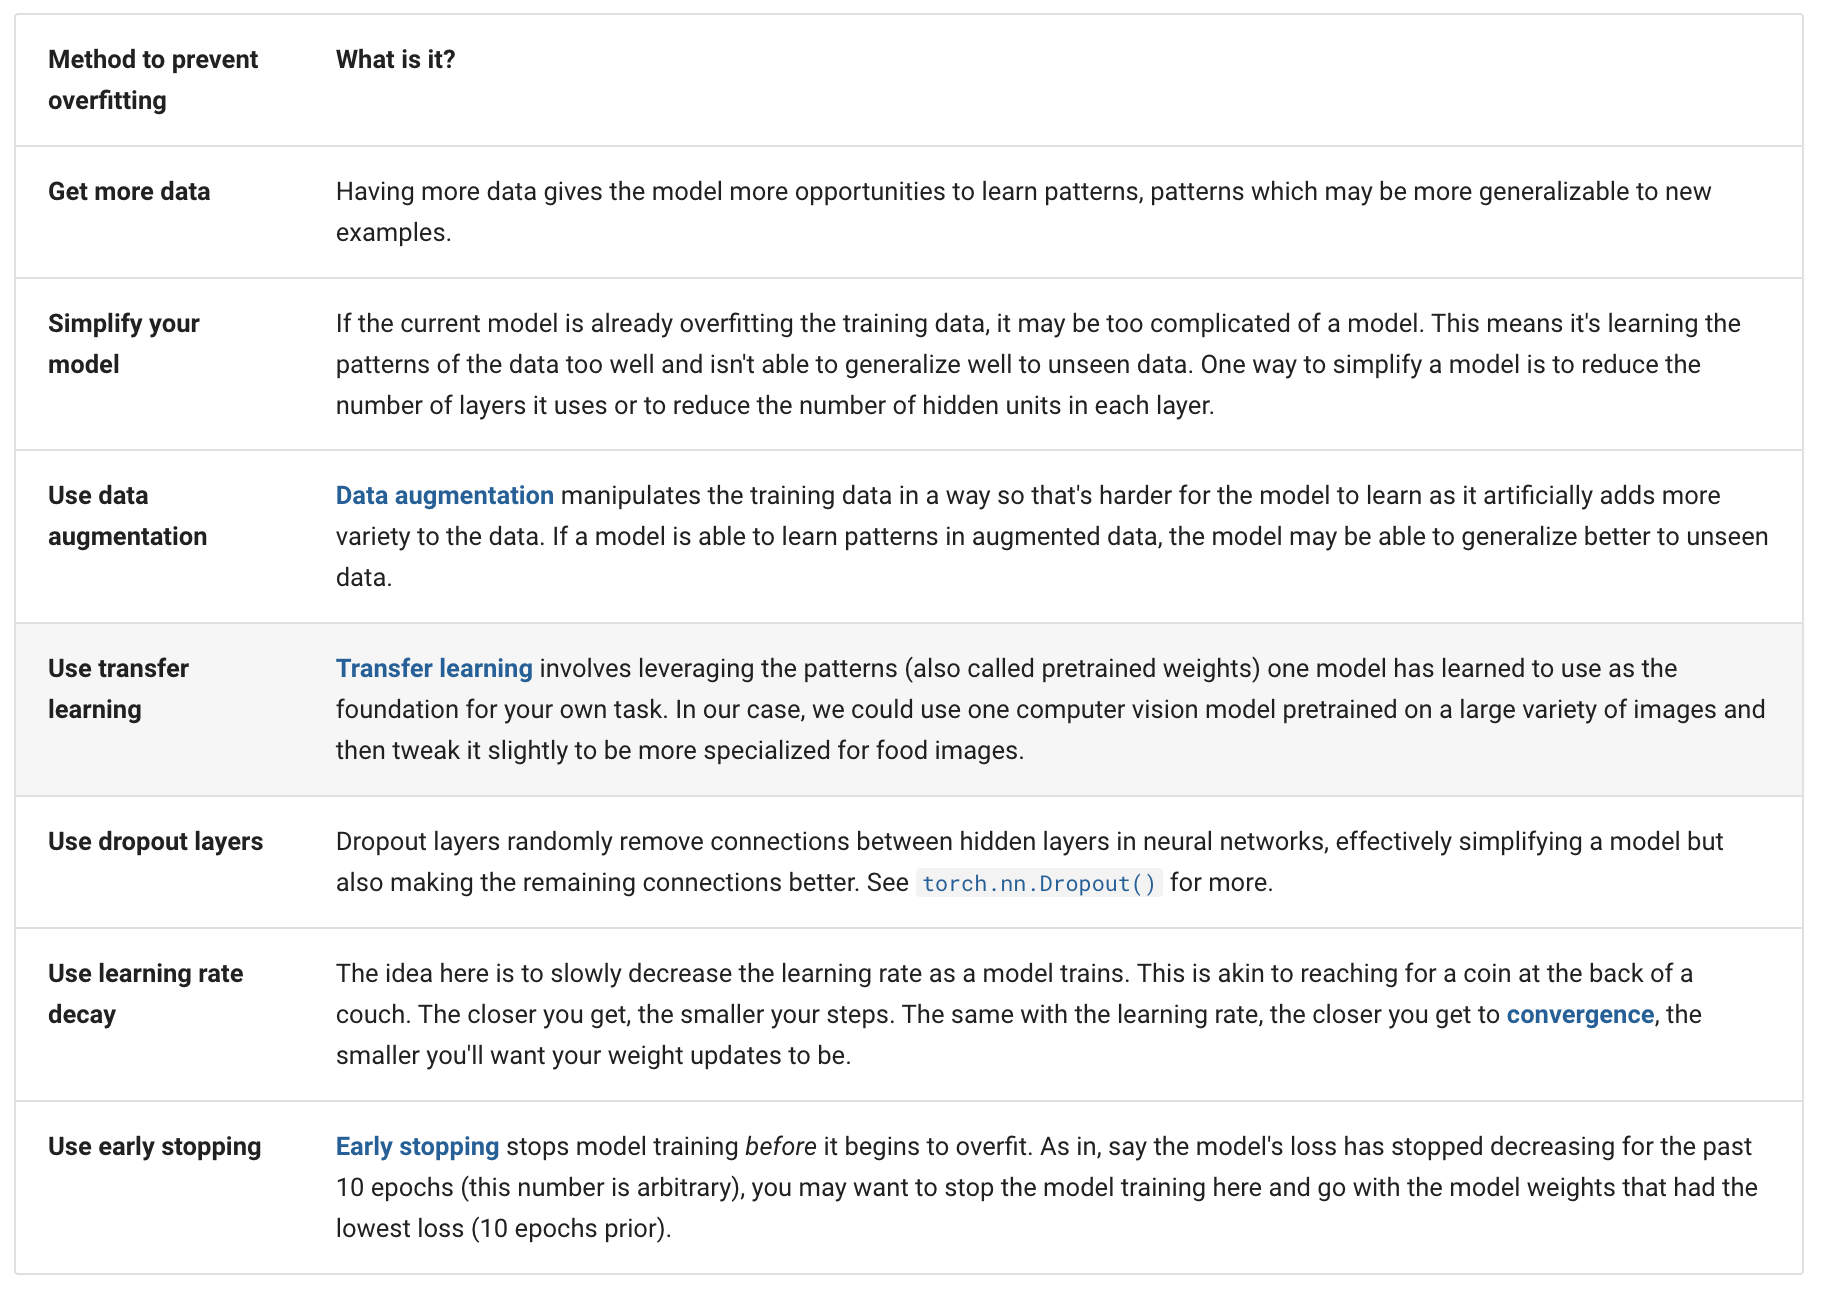

How to deal with underfitting

The balance between overfitting and underfitting

...

### 9. Model 1: TinyVGG with Data Augmentation

In [79]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [80]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1519b02b0>,
 <torch.utils.data.dataloader.DataLoader at 0x15d299cd0>)

In [81]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [82]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1058 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1383 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0803 | train_acc: 0.4258 | test_loss: 1.1687 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1285 | train_acc: 0.3047 | test_loss: 1.1623 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0879 | train_acc: 0.4258 | test_loss: 1.1472 | test_acc: 0.2604
Total training time: 297.816 seconds


In [83]:
plot_loss_curves(model_1_results)

### 10. Compare model results

In [84]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.107833   0.257812   1.136041  0.260417
1    1.084713   0.425781   1.162009  0.197917
2    1.115690   0.292969   1.169686  0.197917
3    1.095543   0.414062   1.138576  0.197917
4    1.098492   0.292969   1.142987  0.197917

In [85]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

### 11. Make a prediction on a custom image

In [86]:
data_path

PosixPath('data')

In [87]:
os.listdir(data_path)

['pizza_steak_sushi.zip', 'FashionMNIST', 'pizza_steak_sushi']

In [88]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [89]:
os.listdir(data_path)

['pizza_steak_sushi.zip',
 'FashionMNIST',
 '04-pizza-dad.jpeg',
 'pizza_steak_sushi']

11.1 Loading in a custom image with PyTorch

torchvision.io를 사용해서 이미지 uint8(0~255) torch.Tensor로 변환할 수있다.

In [90]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

- 그런데 우리 모델은 torch.float32 (0 ~1) 타입을 입력으로 받는다.  

이 샘플을 바로 입력하면 에러를 발생시킨다.

In [91]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [96]:
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.1371,  0.1471, -0.0571],
                        [ 0.1669, -0.0521,  0.0292],
                        [-0.1017,  0.1039,  0.1598]],
              
                       [[-0.1555,  0.1501,  0.0200],
                        [ 0.1280,  0.0124,  0.0795],
                        [-0.0406,  0.1335,  0.0144]],
              
                       [[-0.1053,  0.0312, -0.1056],
                        [-0.0389, -0.0917,  0.1151],
                        [-0.1674, -0.1043, -0.0695]]],
              
              
                      [[[-0.1164,  0.0174, -0.1923],
                        [ 0.1742, -0.1640,  0.1482],
                        [ 0.0330, -0.0615,  0.1200]],
              
                       [[ 0.0286,  0.1541,  0.0189],
                        [-0.0620,  0.0499, -0.0534],
                        [ 0.0803,  0.1709,  0.1117]],
              
                       [[-0.0858,  0.1097,  0.0320],
                 

이미지 데이터 타입과 범위를 조정해주자.

In [97]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

11.2 Predicting on custom images with a trained PyTorch model

In [98]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [99]:
# Plot custom image
plt.imshow(custom_image_uint8.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_uint8.shape}")
plt.axis(False);

In [100]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [110]:
custom_image_transformed.unsqueeze(dim = 0).shape

torch.Size([1, 3, 64, 64])

다시 예측해보자.

In [111]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim = 0))

In [112]:
custom_image_pred

tensor([[ 0.1174,  0.0154, -0.1428]])

만약 gpu를 쓰고 있다면 이미지와 데이터가 서로 다른 곳에 위치해서 연산이 안될수도 있다. 따라서 다음과 같이 입력해주는 것이 좋다.

In [113]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim = 0).to(device))

In [114]:
custom_image_pred

tensor([[ 0.1174,  0.0154, -0.1428]])

In [115]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1174,  0.0154, -0.1428]])
Prediction probabilities: tensor([[0.3740, 0.3377, 0.2883]])
Prediction label: tensor([0])


In [116]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

**중요**

모델이 예측을 잘하는 것처럼 보인다.   
그런데 예측확률을 살펴보자.

In [117]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3740, 0.3377, 0.2883]])

각 클래스에 대한 예측확률이 비슷하다.

이는 다음을 내포한다.  
- 모델이 세가지 클래스를 동시에 예측하려고 한다. (피자, 스테이크, 스시가 포함된 이미지가 있을 수 있음)  
- 모델은 무엇을 예측하고자 하는지 알지 못하기 때문에 각 클래스에 비슷한 값을 할당한다.

여기서는 두번째에 해당한다.

11.3 Putting custom image prediction together: building a function

- Takes in a target image path and converts to the right datatype for our model (torch.float32).
- Makes sure the target image pixel values are in the range [0, 1].
- Transforms the target image if necessary.
- Makes sure the model is on the target device.
- Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
- Converts the model's output logits to prediction probabilities.
- Converts the prediction probabilities to prediction labels.
- Plots the target image alongside the model prediction and prediction probability.

In [118]:
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str] = None,
                       transform=None,
                       device: torch.device = device):
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


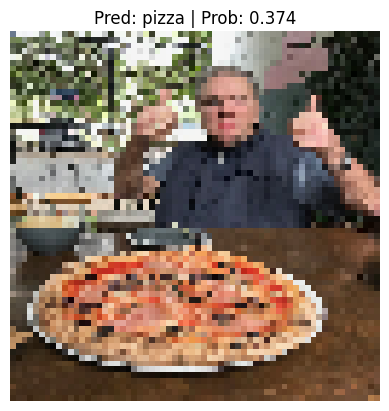

In [119]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

- 이미지가 64*64로 축소되어서 픽셀이 크게 보인다.